#### 개발환경
 - OS : window 10
 - language : Python 3.8.3
 - enviorment : Google Colab
 - panads version: 1.0.5
 - numpy version: 1.19.5
 - matplotlib version: 3.2.2
 - seaborn version: 0.10.1
 - requests version: 2.24.0
 - BeautifulSoup4 version: 4.9.1
 - xmltodict version: 0.12.0
 - json5 version: 0.9.5
 - scikit-learn version: 0.23.1
 - warnings : 버전확인불가

# PART I : Crawling

In [13]:
!pip install xmltodict

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import xmltodict
import json
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import *
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import warnings as w 
w.filterwarnings('ignore')
plt.figure(figsize=(13,13))
%matplotlib inline

In [20]:
file_path = './data/'
cus = pd.read_csv(file_path + 'cus_info.csv')
iem = pd.read_csv(file_path + 'iem_info.csv')
hist = pd.read_csv(file_path + 'stk_bnc_hist.csv')
train = pd.read_csv(file_path + 'stk_hld_train.csv')
test = pd.read_csv(file_path + 'stk_hld_test.csv')

submisson = pd.read_csv(file_path + 'sample_submission.csv')

In [21]:
train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

#### train_data, test_data, hist_data 각각에 존재하는 주식종목코드  파악

In [22]:
train_code = set(train_data['iem_cd'])
test_code = set(test_data['iem_cd'])
hist_code = set(hist['iem_cd'])

print(f'train_data 주식종목 수 :{len(train_code)}')
print(f'test_data 주식종목 수 :{len(test_code)}')
print(f'hist_data 주식종목 수 :{len(hist_code)}')

train_data 주식종목 수 :2784
test_data 주식종목 수 :2708
hist_data 주식종목 수 :2926


#### iem 파일에 존재하는 종목코드, 주식종목업종 확인

In [23]:
# ime에 존재하는 종목코드, 주식종목업종 DataFrame
code_name = iem[['iem_cd','iem_krl_nm']]
count = -1
for i in code_name['iem_cd']:
  count +=1
  code_name['iem_cd'][count] = i[1:]
code_name

,iem_cd,iem_krl_nm
0,000020,동화약품
1,000080,하이트진로
2,000180,성창기업지주
3,000227,유유제약2우B
4,000325,노루홀딩스우
...,...,...
3074,383310,에코프로에이치엔
3075,385520,KODEX K-미래차액티브
3076,388280,KBSTAR Fn컨택트대표
3077,388420,KBSTAR 비메모리반도체액티브


#### 네이버 금융 차트영역에서 일봉 데이터 크롤링

In [24]:
def get_stock(code, name, count):
  url = f'https://fchart.stock.naver.com/sise.nhn?symbol={code}&timeframe=day&count={count}&requestType=0'
  res = requests.get(url)
  dt = xmltodict.parse(res.text)
  js = json.dumps(dt,indent=4)
  js = json.loads(js)

  data = pd.json_normalize(js['protocol']['chartdata']['item'])
  df = data['@data'].str.split('|',expand = True)
  df.columns = ['날짜','시가','고가','저가','종가','거래량']
  df['기업명'] = str(name)
  
  return df

#### 각 기업별로 10년치 시가,고가,저가,종가,거래량,기업명을 크롤링

#### 데이터 크기가 커질 것으로 예상되어, 총 4번에 나누어 크롤링 진행(df_1,df_2,df_3,df_4)

In [25]:
# tmp(아진에스텍까지 주가) 작업완료
# 코드실행시간 5분
tmp = []
error_list = []
idx = -1
for index,row in code_name.iloc[:291].iterrows():
  idx+=1
  try:
    tmp.append(get_stock(row['iem_cd'],row['iem_krl_nm'],'2000'))
  except:
    print(idx,'번 째 종목')
    print('종목코드:',row['iem_cd'],'기업명:',row['iem_krl_nm'],'에서 오류발생')
    error_list.append([row['iem_cd'],row['iem_krl_nm']])


In [28]:
# 아진에스텍까지
df_1=pd.concat(tmp,ignore_index=True)
df_1

,날짜,시가,고가,저가,종가,거래량,기업명
0,20130819,6730,6730,6550,6580,86513,동화약품
1,20130820,6570,6590,6360,6410,106730,동화약품
2,20130821,6410,6590,6230,6380,66310,동화약품
3,20130822,6300,6300,6110,6120,119820,동화약품
4,20130823,6140,6220,6020,6120,83828,동화약품
...,...,...,...,...,...,...,...
573159,20211001,8680,9020,8510,8580,237459,아진엑스텍
573160,20211005,8570,8570,7930,7940,283896,아진엑스텍
573161,20211006,7940,8150,7500,7550,217704,아진엑스텍
573162,20211007,7640,8220,7620,8150,189591,아진엑스텍


In [29]:
# 아진에스텍까지의 기업 csv로 저장
df_1.to_csv('df_1.csv',encoding ='euc-kr')

#### 아진에스텍 이후

In [30]:
#해성피티씨부터 자이에스앤디까지
#코드실행시간 8분
tmp2 = []
idx=-1
for index,row in code_name.iloc[291:701].iterrows():
  idx+=1
  try:
    tmp2.append(get_stock(row['iem_cd'],row['iem_krl_nm'],'2000')) 
  except:
    print(idx,'번 째 종목')
    print('종목코드:',row['iem_cd'],'기업명:',row['iem_krl_nm'],'에서 오류발생')
    error_list.append([row['iem_cd'],row['iem_krl_nm']])

1 번 째 종목
종목코드: 060080 기업명: 제4기한국 에서 오류발생
194 번 째 종목
종목코드: 142220 기업명: 이씨스 에서 오류발생
197 번 째 종목
종목코드: 145730 기업명: 솔젠트 에서 오류발생
205 번 째 종목
종목코드: 153760 기업명: 이리언스 에서 오류발생
210 번 째 종목
종목코드: 158320 기업명: 현대엠엔소프트 에서 오류발생
215 번 째 종목
종목코드: 169830 기업명: 네이처리퍼블릭 에서 오류발생
231 번 째 종목
종목코드: 184390 기업명: 한국코러스 에서 오류발생
243 번 째 종목
종목코드: 199890 기업명: 티이씨씨 에서 오류발생
258 번 째 종목
종목코드: 213930 기업명: 파로스백신 에서 오류발생
289 번 째 종목
종목코드: 235370 기업명: 로보케어 에서 오류발생
291 번 째 종목
종목코드: 236490 기업명: 충만 에서 오류발생
298 번 째 종목
종목코드: 240600 기업명: 유진테크놀로지 에서 오류발생
301 번 째 종목
종목코드: 241660 기업명: 하임바이오 에서 오류발생
304 번 째 종목
종목코드: 244290 기업명: 이루모 에서 오류발생
305 번 째 종목
종목코드: 244310 기업명: 세미스트 에서 오류발생
309 번 째 종목
종목코드: 247580 기업명: 엑스드론 에서 오류발생
321 번 째 종목
종목코드: 255890 기업명: 이에스에스콤 에서 오류발생
325 번 째 종목
종목코드: 258840 기업명: 세진하이테크 에서 오류발생
326 번 째 종목
종목코드: 259070 기업명: 제이에스테크 에서 오류발생
351 번 째 종목
종목코드: 271530 기업명: 진올바이오테크놀러지 에서 오류발생
353 번 째 종목
종목코드: 272810 기업명: 펀진 에서 오류발생
358 번 째 종목
종목코드: 279120 기업명: 호그린에어 에서 오류발생
362 번 째 종목
종목코드: 284710 기업명: 엠비지 에서 오류발생
364 번 째 종목
종목코드: 2

In [31]:
# 해성피티씨부터 자이에스앤디까지
df_2=pd.concat(tmp2,ignore_index=True)
df_2.to_csv('df_2.csv',encoding ='euc-kr')

In [32]:
# 캐리소프트부터 KODEX인버스까지
# 코드실행시간 8분
tmp3 = []
idx=-1
for index,row in code_name.iloc[701:1201].iterrows():
  idx+=1
  try:
    tmp3.append(get_stock(row['iem_cd'],row['iem_krl_nm'],'2000')) 
  except:
    print(idx,'번 째 종목')
    print('종목코드:',row['iem_cd'],'기업명:',row['iem_krl_nm'],'에서 오류발생')
    error_list.append([row['iem_cd'],row['iem_krl_nm']])

13 번 째 종목
종목코드: 32316K 기업명: 테바1우 에서 오류발생
24 번 째 종목
종목코드: 336730 기업명: 비욘드바이오 에서 오류발생
28 번 째 종목
종목코드: 340750 기업명: 씨엘바이오 에서 오류발생
29 번 째 종목
종목코드: 34385K 기업명: 금축인터내셔널1우 에서 오류발생
34 번 째 종목
종목코드: 350340 기업명: 신명메디에스 에서 오류발생
57 번 째 종목
종목코드: 376430 기업명: 프라나랩 에서 오류발생
337 번 째 종목
종목코드: 049450 기업명: 지아이티 에서 오류발생
496 번 째 종목
종목코드: 113300 기업명: 세명테크 에서 오류발생


In [ ]:
# # 캐리소프트부터 KODEX인버스까지
# df_3=pd.concat(tmp3,ignore_index=True)
# df_3.to_csv('df_3.csv',encoding ='euc-kr')

In [ ]:
# # 연우부터 마지막까지
# # 코드 실행시간 29분
# tmp4 = []
# idx=-1
# for index,row in code_name.iloc[1201:].iterrows():
#   idx+=1
#   try:
#     tmp4.append(get_stock(row['iem_cd'],row['iem_krl_nm'],'2000')) 
#   except:
#     print(idx,'번 째 종목')
#     print('종목코드:',row['iem_cd'],'기업명:',row['iem_krl_nm'],'에서 오류발생')
#     error_list.append([row['iem_cd'],row['iem_krl_nm']])

17 번 째 종목
종목코드: 123780 기업명: 레오모터스 에서 오류발생
53 번 째 종목
종목코드: 163290 기업명: 수양켐텍 에서 오류발생
57 번 째 종목
종목코드: 169140 기업명: 경인자기관리부동산투자회사 에서 오류발생
65 번 째 종목
종목코드: 177850 기업명: 무한비트 에서 오류발생
67 번 째 종목
종목코드: 179090 기업명: 이카이스 에서 오류발생
103 번 째 종목
종목코드: 210160 기업명: 팍스넷경제티브이 에서 오류발생
127 번 째 종목
종목코드: 228980 기업명: 지엔티파마 에서 오류발생
131 번 째 종목
종목코드: 234760 기업명: 고위드 에서 오류발생
136 번 째 종목
종목코드: 239280 기업명: 필로시스 에서 오류발생
141 번 째 종목
종목코드: 24251Q 기업명: 발레앤모델6우 에서 오류발생
151 번 째 종목
종목코드: 249680 기업명: 메디오젠 에서 오류발생
152 번 째 종목
종목코드: 250990 기업명: 씨티씨생명과학 에서 오류발생
161 번 째 종목
종목코드: 254650 기업명: 성보 에서 오류발생
167 번 째 종목
종목코드: 258340 기업명: 센트롤 에서 오류발생
169 번 째 종목
종목코드: 258890 기업명: 미라셀 에서 오류발생
172 번 째 종목
종목코드: 261780 기업명: 차백신연구소 에서 오류발생
186 번 째 종목
종목코드: 266930 기업명: 비바이오 에서 오류발생
196 번 째 종목
종목코드: 276040 기업명: 스코넥엔터테인먼트 에서 오류발생
202 번 째 종목
종목코드: 278470 기업명: 에이피알 에서 오류발생
208 번 째 종목
종목코드: 281630 기업명: 에잇퍼센트 에서 오류발생
211 번 째 종목
종목코드: 283970 기업명: 쿼럼바이오 에서 오류발생
218 번 째 종목
종목코드: 289190 기업명: 제이시스메디칼 에서 오류발생
236 번 째 종목
종목코드: 298130 기업명: 옥천당 에서 오류발생
239 번 째 종목
종

In [ ]:
# df_4=pd.concat(tmp4,ignore_index=True)
# df_4.to_csv('df_4.csv',encoding ='euc-kr')

#### 크롤링이 불가능 했던 error_list 조사결과, 비상장기업이 대부분이었으므로, 주가를 얻는 것이 불가능하다고 판단

#### df1~df4 병합

In [5]:
# df1 = pd.read_csv('df_1.csv',encoding='euc-kr')
# df2 = pd.read_csv('df_2.csv',encoding='euc-kr')
# df3 = pd.read_csv('df_3.csv',encoding='euc-kr')
# df4 = pd.read_csv('df_4.csv',encoding='euc-kr')
# sp = pd.concat([df1,df2,df3,df4],ignore_index=True) # sp는 error_list를 제외한 모든 종목, 2011년 주가부터

#### stock_price는 sp 에서 2015년 12월1일 부터 2020년 12월 31일까지의 데이터만 포함

In [6]:
# stock_price = sp.loc[(20151201<sp['날짜']) & (sp['날짜']<20201231),]

In [7]:
# stock_price

,Unnamed: 0,날짜,시가,고가,저가,종가,거래량,기업명
563,563,20151202,8220,8260,7900,7900,208479,동화약품
564,564,20151203,7830,7850,7650,7740,164412,동화약품
565,565,20151204,7610,7710,7560,7570,116154,동화약품
566,566,20151207,7620,7700,7440,7650,180896,동화약품
567,567,20151208,7640,7780,7410,7500,211408,동화약품
...,...,...,...,...,...,...,...,...
4646989,2618226,20201230,9950,10095,9845,10080,467579,KBSTAR 차이나항셍테크
4647454,2618691,20201224,9970,10083,9940,10064,250532,KODEX K-이노베이션액티브
4647455,2618692,20201228,10118,10197,10039,10044,55898,KODEX K-이노베이션액티브
4647456,2618693,20201229,10192,10371,10192,10371,39694,KODEX K-이노베이션액티브


# Part II : Data Analysis

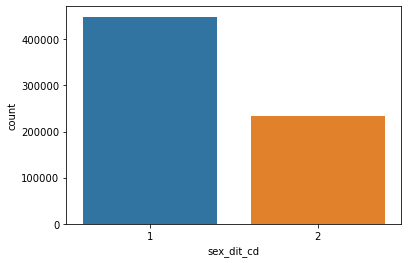

In [62]:
# 남자가 여자보다 더 많이 투자함.
sns.countplot(train_data['sex_dit_cd'])

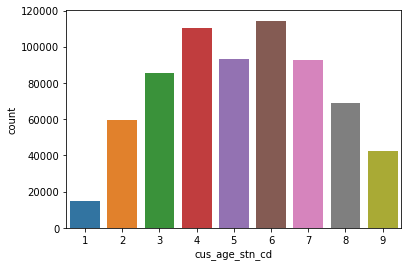

In [63]:
sns.countplot(train_data['cus_age_stn_cd'])

4     162207
99    152710
3     144774
2     104471
5      93268
1      13688
0      10208
9        146
Name: ivs_icn_cd, dtype: int64

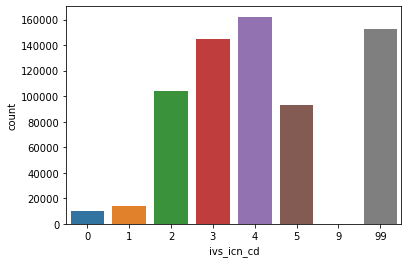

In [64]:
sns.countplot(train_data['ivs_icn_cd'])
train_data['ivs_icn_cd'].value_counts() # 미정의가 15만개로 데이터에서 많은 부분을 차지함.

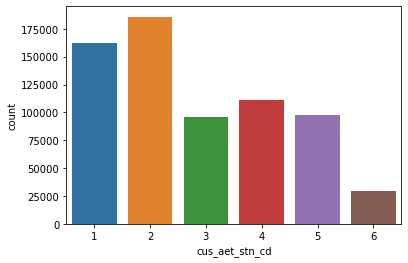

In [65]:
sns.countplot(train_data['cus_aet_stn_cd'])

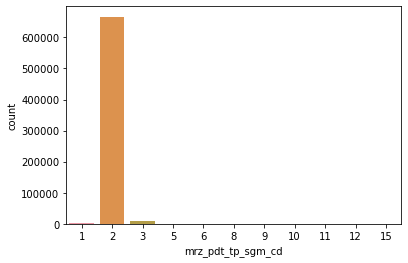

In [66]:
sns.countplot(train_data['mrz_pdt_tp_sgm_cd'])

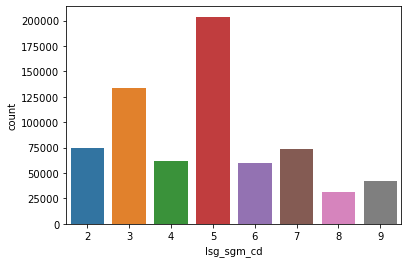

In [67]:
sns.countplot(train_data['lsg_sgm_cd'])

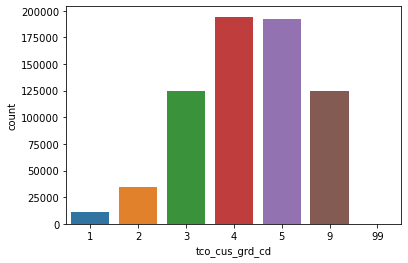

In [68]:
sns.countplot(train_data['tco_cus_grd_cd'])

### 탐색적 데이터 분석(EDA, Exploratory Data Analysis) : 이변량 분석(hold_d와 feature 시각화)
 - target 값인 hold_d와 다양한 variable의 관계를 Graphical Method를 사용하여 시각화 진행

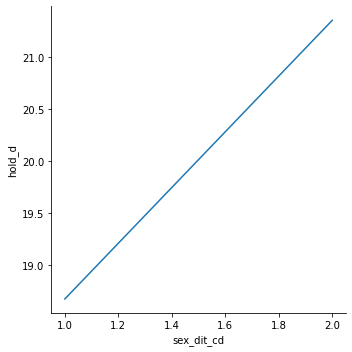

In [70]:
sns.relplot(kind="line", data=train_data, x=train_data.columns[4], y="hold_d", ci=None)

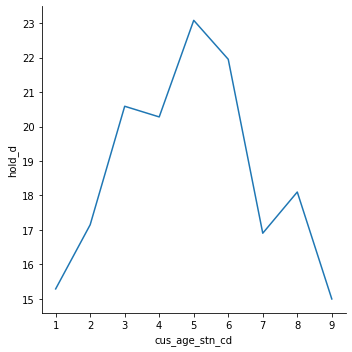

In [71]:
sns.relplot(kind="line", data=train_data, x=train_data.columns[5], y="hold_d", ci=None)

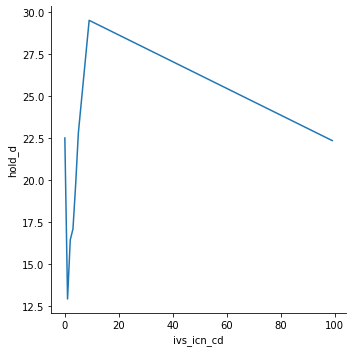

In [72]:
sns.relplot(kind="line", data=train_data, x=train_data.columns[6], y="hold_d", ci=None)

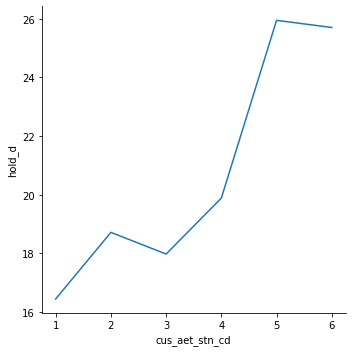

In [73]:
sns.relplot(kind="line", data=train_data, x=train_data.columns[7], y="hold_d", ci=None)

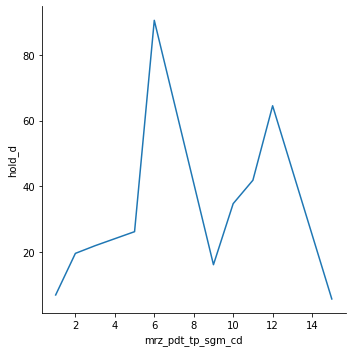

In [74]:
sns.relplot(kind="line", data=train_data, x=train_data.columns[8], y="hold_d", ci=None)

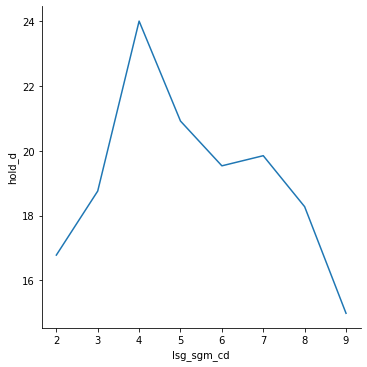

In [ ]:
sns.relplot(kind="line", data=train_data, x=train_data.columns[9], y="hold_d", ci=None)

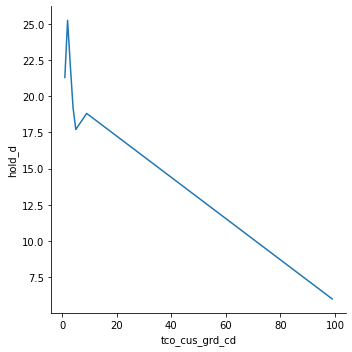

In [75]:
sns.relplot(kind="line", data=train_data, x=train_data.columns[10], y="hold_d", ci=None)

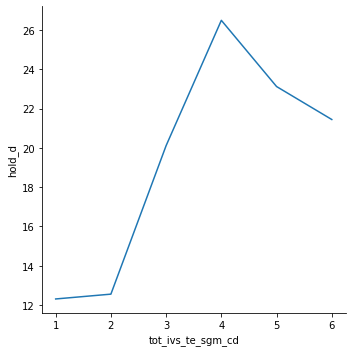

In [76]:
sns.relplot(kind="line", data=train_data, x=train_data.columns[11], y="hold_d", ci=None)

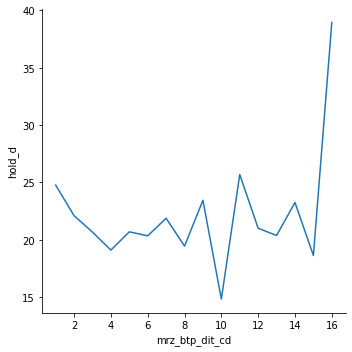

In [77]:
sns.relplot(kind="line", data=train_data, x=train_data.columns[12], y="hold_d", ci=None)

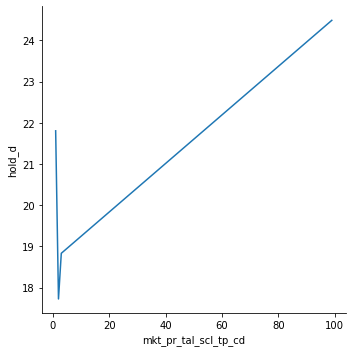

In [78]:
sns.relplot(kind="line", data=train_data, x=train_data.columns[15], y="hold_d", ci=None)

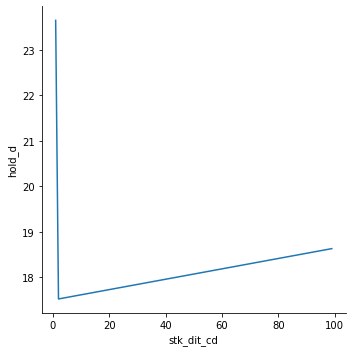

In [79]:
sns.relplot(kind="line", data=train_data, x=train_data.columns[16], y="hold_d", ci=None)

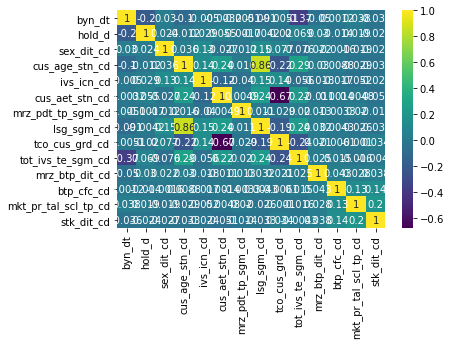

In [80]:
sns.heatmap(train_data.corr(), annot = True, cmap = 'viridis')

### 데이터 전처리(Data Preprocessing)

##### 1. past_d : 0이 나오기 전까지의 보유일자
 - train_data에서의 past_d : hist 데이터의 해당 고객이 해당 종목을 거래할 때 0이 처음 나올 때(처음 전량매도)까지의 보유일자
 - test_data에서의 past_d : hist 데이터의 해당 고객이 해당 종목을 거래할 때의 (최종 거래일 - 최초 거래일). 이는 훈련집합의 고객들은 전량 매도가 이루어지지 않았기 때문에 도입함.

##### 2. hist_d : 모델 학습에서 제외하고, 데이터 후처리에 사용(hist_d + hold_d => 최종 예측 값)

##### 3. 기타 파생변수 : 전체 잔고 /구매수량(average_asset), 주가로부터 RSI 및 MFI 지수 반영(RSI, MFI), 고객-종목별 과거 주식 거래 횟수(count), 주식 보유기간 10일 미만 여부(under_10)

#### 보유기간 기준, 10일 미만 여부 indicator Variable(지시 변수) 생성
 - 훈련집합의 hold_d가 10일 이상이면 1, 그렇지 않으면 0
 - 평가집합의 hist_d가 10일 이상이면 1, 그렇지 않으면 0
의 논리를 활용하여 Dummy 변수를 생성한다.

In [4]:
train_data['under_10'] = None
test_data['under_10'] = None

train_data.loc[train_data['hold_d']<=10,'under_10'] = 1
train_data.loc[train_data['hold_d']>10,'under_10'] = 0

test_data.loc[test_data['hist_d']<=10,'under_10'] = 1
test_data.loc[test_data['hist_d']>10,'under_10'] = 0

print(train_data.shape[1], test_data.shape[1])

18 20


#### 주가 관련 지표 : RSI/MFI 생성 및 결측치 처리 과정
 - Crawling한 주가파일의 변수(주가)를 활용하여 파생변수 RSI 및 MFI 생성
 - RSI 및 MFI의 산출 방법 :
   1. RSI : 해당일 종가의 14일 이동평균을 활용하여 산출
   RSI = RS / (1 + RS) = AU / (AU + AD) * 100
   RS = AU / AD
   AU = 최근 14일 중 종가 상승분 합 / 14
   AD = 최근 14일 중 종가 하락분 합 / 14

   2. MFI : 해당일 고가, 저가, 종가의 산술평균 값을 기저(basis)로 14일 이동평균을 활용하여 산출
 - RSI 및 MFI의 결측치 처리 방법 :
  1. 주가가 존재하지 않은 비상장기업의 RSI, MFI수치는 1년 평균 개장일수(245일)를 기준으로 산출한다.
   - RSI : 훈련집합에 대해서, hold_d가 245일 이상인 경우 70, 그 반대의 경우 30으로 결측치를 처리하며, 평가집합에 대해서 hist_d가 245 이상일 경우 70, 그 반대의 경우 30으로 결측치를 처리한다.(70, 30의 정량적 수치는 주식시장 domain에서 비롯되었다.)
   - MFI : 훈련집합에 대해서, hold_d가 245일 이상인 경우 80, 그 반대의 경우 20으로 결측치를 처리하며, 평가집합에 대해서 hist_d가 245 이상일 경우 80, 그 반대의 경우 20으로 결측치를 처리한다.
  2. 주가가 존재하지만, 14일 이동평균을 구해야하는 공식에 의해 산출되지 않은 '기타 결측치'는 해당 종목의 RSI, MFI 평균으로 결측치를 Imputation한다.

In [11]:
sp = pd.read_csv('stock_price.csv', encoding='cp949') # stock_price는
sp['날짜'] = sp['날짜'].astype(str)
sp['new'] = sp[['날짜','기업명']].apply(','.join, axis=1)
sp.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [12]:
sp.head()

,날짜,시가,고가,저가,종가,거래량,기업명,new
0,20151202,8220,8260,7900,7900,208479,동화약품,"20151202,동화약품"
1,20151203,7830,7850,7650,7740,164412,동화약품,"20151203,동화약품"
2,20151204,7610,7710,7560,7570,116154,동화약품,"20151204,동화약품"
3,20151207,7620,7700,7440,7650,180896,동화약품,"20151207,동화약품"
4,20151208,7640,7780,7410,7500,211408,동화약품,"20151208,동화약품"


In [9]:
data_list = []
for idx in range(len(sp)) :
  try :
    if sp['기업명'].values[idx] != sp['기업명'].values[idx+1] :
      data_list.append(idx)
    else :
      continue
  except :
    continue

sp['RSI'] = 0

def calcRSI(df, period=14) :
  U = np.where(df.diff(1)['종가']>0, df.diff(1)['종가'], 0)
  D = np.where(df.diff(1)['종가']<0, df.diff(1)['종가']*(-1), 0)
  AU = pd.DataFrame(U).rolling(window=period).mean()
  AD = pd.DataFrame(D).rolling(window=period).mean()
  RSI = AU/(AD+AU)*100
  return RSI

data = sp.iloc[:data_list[0]+1,:][['종가', 'RSI']]
sp['RSI'].loc[data.index] = calcRSI(data)[0].values

data = sp.iloc[data_list[-1]+1:,:][['종가', 'RSI']]
sp['RSI'].loc[data.index] = calcRSI(data)[0].values

for idx in range(len(data_list)) :
  try :
    data = sp.loc[data_list[idx]+1 : data_list[idx+1],:][['종가','RSI']]
    data['RSI'] = calcRSI(data)[0].values
    sp['RSI'].loc[data.index] = data['RSI']
  except :
    continue

df = sp.copy()

df['TP'] = (df['고가']+df['저가']+df['종가'])/3
df['PMF'] = 0
df['NMF'] = 0
for i in range(len(df['종가'])-1):
  try :
      # 당일의 중심가격이 전일의 중심가격보다 크면 긍정적 현금흐름
      if df['TP'].values[i] < df['TP'].values[i+1]:
          df['PMF'].values[i+1] = df['TP'].values[i+1]*df['거래량'].values[i+1]
          df['NMF'].values[i+1] = 0
      # 당일의 중심가격이 전일의 중심가격보다 작거나 같으면 부정적 현금흐름
      else:
          df['NMF'].values[i+1] = df['TP'].values[i+1]*df['거래량'].values[i+1]
          df['PMF'].values[i+1] = 0
  except :
    continue
df['MFR'] = df['PMF'].rolling(window=14).sum()/df['NMF'].rolling(window=14).sum()
df['MFI14'] = 100 - 100/(1+df['MFR'])

df.to_csv('stock_price(ver.RSI+MFI).csv', index=False)

In [10]:
sp = pd.read_csv('stock_price(ver.RSI+MFI).csv') # 상단의 함수 및 반복문을 통해 만들어놓은 RSI+MFI열이 추가된 stock_price Data load
sp['날짜'] = sp['날짜'].astype(str)
sp['new'] = sp[['날짜','기업명']].apply(','.join, axis=1)
sp

,날짜,시가,고가,저가,종가,거래량,기업명,new,RSI,TP,PMF,NMF,MFR,MFI14
0,20151202,8220,8260,7900,7900,208479,동화약품,"20151202,동화약품",NaN,8020.000000,0,0,NaN,NaN
1,20151203,7830,7850,7650,7740,164412,동화약품,"20151203,동화약품",NaN,7746.666667,0,1273644960,NaN,NaN
2,20151204,7610,7710,7560,7570,116154,동화약품,"20151204,동화약품",NaN,7613.333333,0,884319120,NaN,NaN
3,20151207,7620,7700,7440,7650,180896,동화약품,"20151207,동화약품",NaN,7596.666667,0,1374206613,NaN,NaN
4,20151208,7640,7780,7410,7500,211408,동화약품,"20151208,동화약품",NaN,7563.333333,0,1598949173,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999592,20201230,9950,10095,9845,10080,467579,KBSTAR 차이나항셍테크,"20201230,KBSTAR 차이나항셍테크",NaN,10006.666667,4678907193,0,0.794267,44.266925
2999593,20201224,9970,10083,9940,10064,250532,KODEX K-이노베이션액티브,"20201224,KODEX K-이노베이션액티브",NaN,10029.000000,2512585428,0,0.871079,46.554905
2999594,20201228,10118,10197,10039,10044,55898,KODEX K-이노베이션액티브,"20201228,KODEX K-이노베이션액티브",NaN,10093.333333,564197146,0,0.882706,46.884971
2999595,20201229,10192,10371,10192,10371,39694,KODEX K-이노베이션액티브,"20201229,KODEX K-이노베이션액티브",NaN,10311.333333,409298065,0,0.887701,47.025516


In [11]:
train_data['byn_dt'] = train_data['byn_dt'].astype(str)
train_data['new'] = train_data[['byn_dt', 'iem_krl_nm']].apply(','.join, axis=1)
train_data = train_data.merge(sp, on='new', how='left')
train_data = train_data.drop_duplicates(['act_id','iem_cd','byn_dt'])
train_data.index = range(train_data.shape[0])
df = train_data.loc[train_data['종가'].isna()][['hold_d', 'RSI', 'MFI14']]
df['indicator_RSI'] = np.where(df['hold_d'] >= 245, 'O', 'X')
df['indicator_MFI'] = np.where(df['hold_d'] >= 245, 'O', 'X')
df['RSI'] = df['indicator_RSI'].map({'O' : 70, 'X' : 30})
df['MFI14'] = df['indicator_MFI'].map({'O' : 80, 'X' : 20})
train_data['RSI'].values[df.index] = df['RSI']
train_data['MFI14'].values[df.index] = df['MFI14']

test_data['byn_dt'] = test_data['byn_dt'].astype(str)
test_data['new'] = test_data[['byn_dt', 'iem_krl_nm']].apply(','.join, axis=1)
test_data = test_data.merge(sp, on='new', how='left')
test_data = test_data.loc[test_data['submit_id'].drop_duplicates().index]
test_data.index = (range(len(test_data)))
df = test_data.loc[test_data['종가'].isna()][['hist_d','RSI', 'MFI14']]
df['indicator_RSI'] = np.where(df['hist_d'] >= 245, 'O', 'X')
df['indicator_MFI'] = np.where(df['hist_d'] >= 245, 'O', 'X')
df['RSI'] = df['indicator_RSI'].map({'O' : 70, 'X' : 30})
df['MFI14'] = df['indicator_MFI'].map({'O' : 80, 'X' : 20})
train_data['RSI'].values[df.index] = df['RSI']
train_data['MFI14'].values[df.index] = df['MFI14']

In [12]:
gb_train = train_data.groupby(['iem_krl_nm']).mean()
nan_df = train_data.loc[np.where(train_data['RSI'].isna())[0]]

for col in range(gb_train.shape[0]) :
  try :
    nan_df['RSI'].values[col] = gb_train.loc[gb_train.index == f'{nan_df["iem_krl_nm"].values[col]}']['RSI'].values[0]
  except :
    continue

train_data["RSI"].loc[nan_df.index]= nan_df['RSI'].values

In [13]:
gb_train = train_data.groupby(['iem_krl_nm']).mean()
nan_df = train_data.loc[np.where(train_data['MFI14'].isna())[0]]

for col in range(gb_train.shape[0]) :
  try :
    nan_df['MFI14'].values[col] = gb_train.loc[gb_train.index == f'{nan_df["iem_krl_nm"].values[col]}']['MFI14'].values[0]
  except :
    continue

train_data["MFI14"].loc[nan_df.index]= nan_df['MFI14'].values

In [14]:
gb_test = test_data.groupby(['iem_krl_nm']).mean()
nan_df = test_data.loc[np.where(test_data['RSI'].isna())[0]]

for col in range(nan_df.shape[0]) :
  nan_df['RSI'].values[col] = gb_test.loc[gb_test.index == f'{nan_df["iem_krl_nm"].values[col]}']['RSI'].values[0]

test_data["RSI"].loc[nan_df.index]= nan_df['RSI'].values

In [15]:
gb_test = test_data.groupby(['iem_krl_nm']).mean()
nan_df = test_data.loc[np.where(test_data['MFI14'].isna())[0]]

for col in range(nan_df.shape[0]) :
  nan_df['MFI14'].values[col] = gb_test.loc[gb_test.index == f'{nan_df["iem_krl_nm"].values[col]}']['MFI14'].values[0]

test_data["MFI14"].loc[nan_df.index]= nan_df['MFI14'].values

In [16]:
df = train_data.loc[train_data['RSI'].isna()][['hold_d', 'RSI']]
df['indicator'] = np.where(df['hold_d'] >= 245, 'O', 'X')
df['RSI'] = df['indicator'].map({'O' : 70, 'X' : 30})
train_data['RSI'].values[df.index] = df['RSI']

df = test_data.loc[test_data['RSI'].isna()][['hist_d','RSI']]
df['indicator'] = np.where(df['hist_d'] >= 245, 'O', 'X')
df['RSI'] = df['indicator'].map({'O' : 70, 'X' : 30})
test_data['RSI'].values[df.index] = df['RSI']

print(train_data['RSI'].isna().sum(), test_data['RSI'].isna().sum()) # 결측치 여부 확인 가공완료

0 0


In [17]:
df = train_data.loc[train_data['MFI14'].isna()][['hold_d', 'MFI14']]
df['indicator'] = np.where(df['hold_d'] >= 245, 'O', 'X')
df['MFI14'] = df['indicator'].map({'O' : 80, 'X' : 20})
train_data['MFI14'].values[df.index] = df['MFI14']

df = test_data.loc[test_data['MFI14'].isna()][['hist_d','RSI']]
df['indicator'] = np.where(df['hist_d'] >= 245, 'O', 'X')
df['MFI14'] = df['indicator'].map({'O' : 80, 'X' : 20})
test_data['MFI14'].values[df.index] = df['MFI14']

print(train_data['MFI14'].isna().sum(), test_data['MFI14'].isna().sum()) # 결측치 여부 확인 가공완료

0 0


#### 파생변수 : 고객-종목별 과거 거래횟수(변수명 : Count)
 - 해당 고객이 해당 종목의 과거 거래 이력을 센 변수를 파생변수로 생성
 - 예) A고객이 S사 주식을 구매하기 이전에 이미 2번의 매수,매도 이력이 있다면, count(A) = 2

In [18]:
gb_hist = hist.groupby(['act_id','iem_cd']).count().reset_index(drop=False)
gb_hist['identifier'] = gb_hist[['act_id','iem_cd']].apply(','.join, axis=1)
gb_hist.rename(columns={'bse_dt' : 'count'}, inplace=True)

train_data['identifier']= train_data[['act_id','iem_cd']].apply(','.join, axis=1)
train_data = train_data.merge(gb_hist[['identifier','count']], on='identifier', how='inner')
train_data.drop(['identifier'], axis=1, inplace=True)

test_data['identifier']= test_data[['act_id','iem_cd']].apply(','.join, axis=1)
test_data = test_data.merge(gb_hist[['identifier','count']], on='identifier', how='inner')
test_data.drop(['identifier'], axis=1, inplace=True)

print(train_data.shape[1], test_data.shape[1])

33 35


### 범주형 변수 → 각 범주별 보유기간 평균으로 대체
 - 주어진 훈련집합 및 평가집합의 Variable은 모두 명목형 변수로 회귀 모델에 바로 적용할 경우, OneHotEncoding이 필요함. 그러나, 각각이 많은 범주로 이루어져 있어 수 많은 변수가 회귀모형의 Input이 될 것으로 보이고, 이는 모델의 복잡도를 증가시켜 차원의 저주에 빠질 문제가 커질 우려가 있어, 이를 모두 수치형데이터(훈련 집합의 경우 : 각 범주별 hold_d의 평균 / 평가 집합의 경우 : 각 범주별 hist_d의 경우)로 바꾸어주었음.
 - 여기서 평균의 기준을 hold_d, hist_d를 사용한 이유는, 종속변수와의 상관성 또한 회귀문제를 해결함에 있어 중요하기 때문임.

In [19]:
categorical_variable = ['sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd','cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'btp_cfc_cd', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd']

for col in categorical_variable :
  gb = train_data.groupby([f'{col}']).mean()['hold_d']
  dic = {}
  for i in range(gb.shape[0]) :
    dic[f'{gb.index[i]}'] = f'{gb.values[i]}'
  train_data[f"{col}"] = train_data[f'{col}'].astype(str).replace(to_replace=dic)
train_data

,act_id,iem_cd,byn_dt,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,under_10,new,날짜,시가,고가,저가,종가,거래량,기업명,RSI,TP,PMF,NMF,MFR,MFI14,count
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,18.677614329540184,14.99368520263902,17.103243676350726,18.715246793647033,19.608072330385607,14.987740764316195,17.702088196065354,23.119425618172254,19.437650147361122,GS건설,23.279391304347826,21.806780873810926,23.651184964114755,0,"20180726,GS건설",20180726,46500.0,46650.0,42850.0,43000.0,3169657.0,GS건설,37.801609,44166.666667,0.000000e+00,1.399932e+11,0.391346,28.127138,6
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20200116,2,18.677614329540184,14.99368520263902,17.103243676350726,18.715246793647033,19.608072330385607,14.987740764316195,17.702088196065354,23.119425618172254,19.437650147361122,GS건설,23.279391304347826,21.806780873810926,23.651184964114755,1,"20200116,GS건설",20200116,30000.0,30250.0,29800.0,29950.0,233550.0,GS건설,38.356164,30000.000000,7.006500e+09,0.000000e+00,0.906786,47.555743,6
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,18.677614329540184,14.99368520263902,17.103243676350726,18.715246793647033,19.608072330385607,14.987740764316195,17.702088196065354,23.119425618172254,19.437650147361122,삼성전자,25.139455388180764,21.806780873810926,23.651184964114755,0,"20180131,삼성전자",20180131,50020.0,54140.0,49600.0,49900.0,1293626.0,삼성전자,59.584296,51213.333333,6.625090e+10,0.000000e+00,2.373189,70.354460,9
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,18.677614329540184,14.99368520263902,17.103243676350726,18.715246793647033,19.608072330385607,14.987740764316195,17.702088196065354,23.119425618172254,19.437650147361122,코스모신소재,21.79660725543011,17.72399697277038,18.63383736052473,1,"20180517,코스모신소재",20180517,14432.0,17599.0,14432.0,16830.0,3393334.0,코스모신소재,98.445596,16287.000000,5.526723e+10,0.000000e+00,inf,100.000000,3
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,18.677614329540184,14.99368520263902,17.103243676350726,18.715246793647033,19.608072330385607,14.987740764316195,17.702088196065354,23.119425618172254,19.437650147361122,영진약품,17.620061570035915,17.72399697277038,23.651184964114755,0,"20201112,영진약품",20201112,8500.0,8700.0,7670.0,7700.0,24174657.0,영진약품,53.239437,8023.333333,1.939613e+11,0.000000e+00,3.843089,79.352021,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A260660,20180831,1,18.677614329540184,20.279308565064245,19.741459986313785,18.715246793647033,19.608072330385607,18.75789756687727,19.228788136072904,20.111816489147042,19.437650147361122,알리코제약,16.920504032486114,18.832883472279338,18.63383736052473,1,"20180831,알리코제약",20180831,11199.0,12258.0,11199.0,11392.0,3791511.0,알리코제약,80.438220,11616.333333,4.404346e+10,0.000000e+00,17.500520,94.594746,2
681468,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A271980,20201027,1,18.677614329540184,20.279308565064245,19.741459986313785,18.715246793647033,19.608072330385607,18.75789756687727,19.228788136072904,20.111816489147042,19.437650147361122,제일약품,17.620061570035915,17.72399697277038,18.63383736052473,1,"20201027,제일약품",20201027,49000.0,49400.0,46200.0,47050.0,579995.0,제일약품,55.285714,47550.000000,0.000000e+00,2.757876e+10,3.451792,77.537134,2
681469,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A289080,20181121,1,18.677614329540184,20.279308565064245,19.741459986313785,18.715246793647033,19.608072330385607,18.75789756687727,19.228788136072904,20.111816489147042,19.437650147361122,SV인베스트먼트,24.073828937941386,17.72399697277038,18.63383736052473,1,"20181121,SV인베스트먼트",20181121,2185.0,2185.0,2030.0,2083.0,927066.0,SV인베스트먼트,71.239837,2099.333333,0.000000e+00,1.946221e+09,7.994171,88.881

In [20]:
categorical_variable = ['sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd','cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'btp_cfc_cd', 'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd']

for col in categorical_variable :
  gb = test_data.groupby([f'{col}']).mean()['hist_d']
  dic = {}
  for i in range(gb.shape[0]) :
    dic[f'{gb.index[i]}'] = f'{gb.values[i]}'
  test_data[f"{col}"] = test_data[f'{col}'].astype(str).replace(to_replace=dic)
test_data

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,under_10,new,날짜,시가,고가,저가,종가,거래량,기업명,RSI,TP,PMF,NMF,MFR,MFI14,count
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,111.07353786651335,113.01342062193126,96.58530011655012,109.96458532740273,113.32185090719379,113.06063585709603,109.35631989156218,128.7882394119706,109.93359465068019,LG유플러스,155.5,111.61657747744229,115.18057669725569,0,"20200522,LG유플러스",20200522,13300.0,13450.0,13050.0,13150.0,1930122.0,LG유플러스,46.875000,13216.666667,0.000000e+00,2.550978e+10,0.645337,39.222179,1
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,111.07353786651335,113.01342062193126,96.58530011655012,109.96458532740273,113.32185090719379,113.06063585709603,109.35631989156218,128.7882394119706,109.93359465068019,이큐셀,100.21449796144012,128.09171511627906,117.15113936635011,0,"20190823,이큐셀",20190823,65886.0,67406.0,62586.0,64627.0,1783575.0,이큐셀,71.062877,64873.000000,0.000000e+00,1.157059e+11,2.129897,68.050069,2
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,111.07353786651335,113.01342062193126,96.58530011655012,109.96458532740273,113.32185090719379,113.06063585709603,109.35631989156218,128.7882394119706,109.93359465068019,세틀뱅크,99.31759314604503,95.82525737077562,117.15113936635011,0,"20200611,세틀뱅크",20200611,31600.0,31750.0,30450.0,31100.0,241315.0,세틀뱅크,50.295858,31100.000000,0.000000e+00,7.504896e+09,1.173490,53.991052,3
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,111.07353786651335,113.01342062193126,96.58530011655012,109.96458532740273,113.32185090719379,113.06063585709603,109.35631989156218,128.7882394119706,109.93359465068019,파인텍,99.31759314604503,128.09171511627906,117.15113936635011,0,"20200120,파인텍",20200120,2100.0,2285.0,2070.0,2260.0,6615258.0,파인텍,60.000000,2205.000000,1.458664e+10,0.000000e+00,1.666675,62.500120,4
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,111.07353786651335,113.01342062193126,96.58530011655012,109.96458532740273,113.32185090719379,113.06063585709603,109.35631989156218,128.7882394119706,109.93359465068019,카카오게임즈,99.31759314604503,111.61657747744229,92.55181236673774,1,"20201217,카카오게임즈",20201217,46350.0,46850.0,46200.0,46450.0,523303.0,카카오게임즈,30.000000,46500.000000,2.433359e+10,0.000000e+00,0.361074,26.528630,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A000810,20201127,23,IDX70592,0,111.07353786651335,123.89979979025645,123.72115384615384,117.01021170610211,113.32185090719379,122.11298761850489,116.89174179008371,128.7882394119706,103.92989985693849,삼성화재,131.5787886403619,111.61657747744229,115.18057669725569,0,"20201127,삼성화재",20201127,207000.0,210000.0,198500.0,198500.0,546159.0,삼성화재,65.909091,202333.333333,1.105062e+11,0.000000e+00,2.013003,66.810516,6
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005945,20200731,103,IDX70593,0,111.07353786651335,123.89979979025645,123.72115384615384,117.01021170610211,113.32185090719379,122.11298761850489,116.89174179008371,128.7882394119706,103.92989985693849,NH투자증권우,131.5787886403619,123.26714925887624,117.15113936635011,0,"20200731,NH투자증권우",20200731,7500.0,7500.0,7410.0,7440.0,79055.0,NH투자증권우,62.025316,7450.000000,0.000000e+00,5.889598e+08,1.871190,65.171230,9
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A004740,20170704,858,IDX70594,0,111.07353786651335,119.1400155668944,112.0268110337716,109.96458532740273,113.32185090719379,107.90738978750396,110.06125240652548,127.30014407896753,109.93359465068019,보루네오가구,161.73821880838696,128.09171511627906,117.15113936635011,0,"20170704,보루네오가구",20170704,52.0,

#### 예측에 필요 없으리라 생각되는 성별, 연령구간, 고객등급 및 MFI 산출 간 생성된 의미없는 변수 제거
 - 성별, 연령구간은 lifestage 변수의 의미와 중첩되어 제거
 - 고객등급은 자산구간 변수와 의미가 중첩될 것이라 생각되어 제거
 - TP, PMF, NMF, MFR 변수는 MFI 변수의 생성에 사용되어 의미가 중첩되고, 다중공선성 우려되어 제거

In [21]:
train_data = train_data.drop(['sex_dit_cd','cus_age_stn_cd','tco_cus_grd_cd', 'TP', 'PMF', 'NMF', 'MFR'],axis=1)
test_data = test_data.drop(['sex_dit_cd','cus_age_stn_cd','tco_cus_grd_cd', 'TP', 'PMF', 'NMF', 'MFR'],axis=1)
print(train_data.shape[0], train_data.shape[1], test_data.shape[0], test_data.shape[1])

#### DataFrame Transformation
 - hist 데이터의 고객은 train, test데이터에 나뉘어 들어가있음. 이에, hist 데이터로부터 past_d 변수를 생성하기 위해 데이터 프레임을 적절히 변형함.
 - new열은 act_id, iem_cd가 결합된 새로운 열로서, 이를 추후 unified indentifier(유일 식별자)로 활용하여, 데이터 병합에 활용한다.
 - is_holiday, time_transformer 등의 함수는 past_d 변수의 생성을 위해 주식시장 개장일을 계산하기 위해 정의하였다. (여기서 휴장일.csv는 주식시장 도메인 site에서 직접 수집하여 작성하였다.)
 - 주식시장 도메인 URL (휴장일.csv 출처) : https://kr.investing.com/holiday-calendar/

In [31]:
# 주말 제외한 휴일(2016.01.01 ~ 2021.07.31까지)
holiday = pd.read_csv('휴장일.csv')

from datetime import date,datetime,timedelta

# 시작 날짜와 종료 날짜 사이의 날짜들을 리스트로
def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [(start + timedelta(days=i)).strftime("%Y%m%d") for i in range((end-start).days+1)]
    return dates

def is_holiday(yyyy,mm,dd): # yyyy,mm,dd 형식 (1의 자리외에는 0이 들어가지 않음)
  return date(yyyy,mm,dd).weekday() > 4

#time_start부터 time_finish 까지 주말 추출
total_weekend = []
def time_transformer(time_start, time_finish) :
  for i in date_range(time_start, time_finish):
    if i[4] == '0' and i[-2]== '0':
      trans_i = i[:4]+i[5]+i[-1]
      y = int(trans_i[:4])
      m = int(trans_i[4])
      d = int(trans_i[-1])
      if is_holiday(y,m,d) :
        total_weekend.append(i)

    elif i[4] == '0' and i[-2] != '0':
      trans_i = i[:4] + i[-3] + i[-2:]
      y = int(trans_i[:4])
      m = int(trans_i[4])
      d = int(trans_i[-2:])
      if is_holiday(y,m,d) :
         total_weekend.append(i)

    elif i[4] != '0' and i[-2] == '0':
      trans_i = i[:4] + i[4:6] + i[-1]
      y = int(trans_i[:4])
      m = int(trans_i[4:6])
      d = int(trans_i[-1])
      if is_holiday(y,m,d) :
         total_weekend.append(i)

    else:
      trans_i = i
      y = int(trans_i[:4])
      m = int(trans_i[4:6])
      d = int(trans_i[-2:])
      if is_holiday(y,m,d) :
         total_weekend.append(i)
  return(total_weekend)

holiday_2016 = []
holiday_2017 = []
holiday_2018 = []
holiday_2019 = []
holiday_2020 = []
holiday_2021 = []

#16년 1월1일 ~ 21년 7월31일까지 기간 중, 년도별로 주말 리스트
time_transformer('20160101','20210731')
for i in total_weekend:
  if i[3] == '6':
    holiday_2016.append(i)
  elif i[3] == '7':
    holiday_2017.append(i)
  elif i[3] == '8':
    holiday_2018.append(i)
  elif i[3] == '9':
    holiday_2019.append(i)
  elif i[3] == '0':
    holiday_2020.append(i)
  else:
    holiday_2021.append(i)

# 2016 ~ 2021 각 년도별로 주말 + 휴장일 리스트
for i in holiday['휴장일(주말제외)']:
  i=str(i)
  if i[3] == '6':
    holiday_2016.append(i)
  elif i[3] == '7':
    holiday_2017.append(i)
  elif i[3] == '8':
    holiday_2018.append(i)
  elif i[3] == '9':
    holiday_2019.append(i)
  elif i[3] == '0':
    holiday_2020.append(i)
  else:
    holiday_2021.append(i)

holiday_2016.sort()
holiday_2017.sort()
holiday_2018.sort()
holiday_2019.sort()
holiday_2020.sort()
holiday_2021.sort()

holiday_total = holiday_2016+holiday_2017+holiday_2018+holiday_2019+holiday_2020+holiday_2021 #2016년 1월1일~ 2021년 7월31일까지 총 주말+휴일

def opening_term(start,end,holiday_list): # start,end = yyyymmdd형식  ,holiday_list = 휴일 리스트
  term = []
  for i in holiday_list:
    i = int(i)
    if (start <= i) and (i <= end):
      term.append(i)
      
  a = datetime.strptime(str(start),'%Y%m%d')
  b = datetime.strptime(str(end),'%Y%m%d')
  diff = b-a
  return diff.days - len(term)

In [30]:
train['new'] = train[['act_id', 'iem_cd']].apply(','.join, axis=1)
test['new'] = test[['act_id', 'iem_cd']].apply(','.join, axis=1)
hist['new'] = hist[['act_id','iem_cd']].apply(','.join, axis=1)

hist_data = hist.sort_values(by = ['act_id', 'iem_cd', 'bse_dt'], ascending=True)
hist_data.reset_index(inplace=True)
hist_data

,index,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,new
0,1951306,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20190321,A002270,1.0,667000.0,5000.0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...
1,1951307,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20190328,A002270,2.0,1270000.0,5000.0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...
2,1951308,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20190507,A002270,3.0,1815000.0,5000.0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...
3,1951309,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20190716,A002270,4.0,2104000.0,5000.0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...
4,1951310,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20200129,A002270,8.0,2964000.0,5000.0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...
...,...,...,...,...,...,...,...,...
2573834,1555424,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201013,A293490,4.0,196600.0,100.0,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...
2573835,1555425,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201124,A293490,5.0,245500.0,100.0,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...
2573836,1555426,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201214,A293490,0.0,0.0,100.0,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...
2573837,1555427,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20200910,A298040,15.0,1072500.0,5000.0,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...


In [32]:
hist['new'] = hist[['act_id','iem_cd']].apply(','.join, axis=1)
hist_data = hist.sort_values(by = ['act_id', 'iem_cd', 'bse_dt'], ascending=True)
hist_data.reset_index(drop=True, inplace=True)
hist_data

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,new
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20190321,A002270,1.0,667000.0,5000.0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20190328,A002270,2.0,1270000.0,5000.0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20190507,A002270,3.0,1815000.0,5000.0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20190716,A002270,4.0,2104000.0,5000.0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...
4,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20200129,A002270,8.0,2964000.0,5000.0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...
...,...,...,...,...,...,...,...
2573834,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201013,A293490,4.0,196600.0,100.0,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...
2573835,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201124,A293490,5.0,245500.0,100.0,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...
2573836,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201214,A293490,0.0,0.0,100.0,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...
2573837,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20200910,A298040,15.0,1072500.0,5000.0,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...


In [33]:
cut_index = [] # global variable
test_index = []

def data_split(data) :
  # 고객-종목별 데이터 spliter(고객별 종목이 달라지는 구간의 dataframe의 index return)
  for idx in range(len(data)) :
    try :
      if ((data['act_id'][idx] != data['act_id'][idx+1]) | (data['iem_cd'][idx] != data['iem_cd'][idx+1])) :
        cut_index.append(idx+1)
      else :
        continue
    except:
      continue
  return cut_index

def find_testdata_index(data) :
  # 평가집합의 index를 찾아주는 함수(개장일 계산을 위함.)
  for idx in range(len(data)) :
    try :
      if (data['bnc_qty'][cut_index[idx]:cut_index[idx+1]].values[-1] != 0) :
        test_index.append([cut_index[idx], cut_index[idx+1]])
      else :
        continue
    except :
      continue
  return test_index

data_split(hist_data)
find_testdata_index(hist_data)

[[51, 58],
 [65, 72],
 [110, 116],
 [119, 123],
 [128, 141],
 [168, 174],
 [183, 184],
 [184, 186],
 [188, 191],
 [196, 197],
 [199, 202],
 [202, 204],
 [207, 215],
 [336, 392],
 [466, 490],
 [519, 521],
 [521, 529],
 [529, 531],
 [534, 536],
 [536, 537],
 [537, 538],
 [538, 539],
 [541, 542],
 [542, 545],
 [545, 546],
 [546, 547],
 [549, 550],
 [550, 553],
 [589, 594],
 [596, 599],
 [599, 602],
 [624, 628],
 [630, 641],
 [782, 786],
 [848, 850],
 [1079, 1081],
 [1201, 1203],
 [1439, 1442],
 [1442, 1450],
 [1450, 1451],
 [1451, 1452],
 [1452, 1453],
 [1463, 1464],
 [1464, 1465],
 [1469, 1470],
 [1472, 1473],
 [1486, 1487],
 [1490, 1493],
 [1504, 1505],
 [1581, 1589],
 [1595, 1597],
 [1628, 1631],
 [1639, 1640],
 [1642, 1662],
 [2019, 2035],
 [2185, 2193],
 [2211, 2212],
 [2214, 2221],
 [2242, 2256],
 [2260, 2261],
 [2263, 2266],
 [2268, 2281],
 [2281, 2285],
 [2287, 2288],
 [2288, 2289],
 [2289, 2291],
 [2291, 2292],
 [2292, 2293],
 [2293, 2294],
 [2294, 2295],
 [2295, 2296],
 [2296, 2

In [34]:
test_past_d = []

def opening_term_counter(data) :
  # find_testdata_index 함수에서 구한 훈련집합의 고객-종목이 나뉘어지는 index를 활용하여, 훈련집합의 해당 종목 최종거래일과 최초거래일 사이의 개장일을 나타내는 변수인 past_d를 생성하는 함수
  for No in range(len(test_index)) :
    test_past_d.append(opening_term(data[test_index[No][0]:test_index[No][1]]['bse_dt'].values[0],data[test_index[No][0]:test_index[No][1]]['bse_dt'].values[-1], holiday_total))
  return test_past_d

opening_term_counter(hist_data)

[196,
 160,
 160,
 143,
 144,
 28,
 0,
 3,
 2,
 0,
 26,
 4,
 17,
 255,
 113,
 1,
 16,
 20,
 8,
 0,
 0,
 0,
 0,
 35,
 0,
 0,
 0,
 37,
 11,
 3,
 3,
 102,
 150,
 3,
 2,
 1,
 1,
 17,
 159,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 103,
 0,
 204,
 6,
 13,
 0,
 189,
 729,
 27,
 0,
 360,
 419,
 0,
 12,
 85,
 43,
 0,
 0,
 101,
 0,
 0,
 0,
 0,
 0,
 67,
 0,
 0,
 9,
 232,
 179,
 0,
 41,
 5,
 149,
 212,
 0,
 59,
 28,
 93,
 130,
 45,
 61,
 280,
 0,
 59,
 30,
 0,
 153,
 0,
 219,
 0,
 94,
 90,
 29,
 5,
 664,
 214,
 2,
 0,
 612,
 0,
 1,
 193,
 37,
 14,
 0,
 0,
 2,
 1,
 187,
 468,
 9,
 7,
 488,
 0,
 72,
 3,
 82,
 0,
 141,
 189,
 189,
 177,
 11,
 49,
 34,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 91,
 0,
 7,
 1,
 22,
 152,
 2,
 0,
 83,
 120,
 64,
 59,
 32,
 0,
 23,
 94,
 1,
 127,
 32,
 18,
 38,
 20,
 502,
 0,
 7,
 232,
 10,
 28,
 0,
 92,
 5,
 22,
 1,
 28,
 1,
 0,
 5,
 76,
 0,
 114,
 44,
 160,
 79,
 173,
 63,
 152,
 152,
 157,
 76,
 131,
 110,
 10,
 8,
 2,
 84,
 2,
 85,
 9,
 131,
 105,
 109,
 0,
 2,
 3,
 1,
 87,
 8,
 0,
 0,
 

In [35]:
hist_data['past_d'] = [None] * len(hist_data)

for idx in range(len(test_index)) :
  # 위에서 구한 past_d를 hist 데이터에 매핑시키는 과정
  hist_data['past_d'].values[test_index[idx][0] : test_index[idx][1]] = test_past_d[idx]

hist_data['past_d'].value_counts()

0       20834
1        3814
2        3237
3        2900
4        2900
        ...  
1144        4
998         3
869         3
875         3
832         2
Name: past_d, Length: 916, dtype: int64

In [36]:
# 훈련집합에 past_d를 넣는 과정
new_train_data = train_data.sort_values(by = ['act_id','iem_cd', 'byn_dt'], ascending = True)
new_train_data.reset_index(drop=True, inplace=True)

past_d = [None]
for idx in range(len(new_train_data)) :
  try :
    if ((new_train_data['iem_cd'][idx] == new_train_data['iem_cd'][idx+1]) & (new_train_data['act_id'][idx] == new_train_data['act_id'][idx+1])) :
      past_d.append(new_train_data['hold_d'][idx])
    else :
      past_d.append(None)
  except :
    past_d.append('Error')
    continue

new_train_data['past_d'] = past_d[:-1]
new_train_data = new_train_data.replace(np.nan, 0)
new_train_data

,act_id,iem_cd,byn_dt,hold_d,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,under_10,new,날짜,시가,고가,저가,종가,거래량,기업명,RSI,MFI14,count,past_d
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A002270,20190321,350,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,롯데푸드,23.022491251834293,18.832883472279338,18.63383736052473,0,"20190321,롯데푸드",20190321,679000.0,680000.0,662000.0,667000.0,2619.0,롯데푸드,54.166667,55.208570,8,0.0
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005070,20190327,19,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,코스모신소재,21.79660725543011,17.72399697277038,18.63383736052473,0,"20190327,코스모신소재",20190327,14251.0,14341.0,13753.0,13799.0,238287.0,코스모신소재,32.096070,46.699703,2,0.0
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005930,20190320,1,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,삼성전자,25.139455388180764,21.806780873810926,23.651184964114755,1,"20190320,삼성전자",20190320,43800.0,44200.0,43100.0,44050.0,9846242.0,삼성전자,30.714286,27.998597,2,0.0
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A033270,20190326,75,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,유나이티드제약,17.620061570035915,17.72399697277038,18.63383736052473,0,"20190326,유나이티드제약",20190326,25200.0,26100.0,25200.0,26050.0,30040.0,유나이티드제약,40.206186,38.389980,4,0.0
4,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A036000,20190611,133,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,예림당,16.920504032486114,18.832883472279338,18.63383736052473,0,"20190611,예림당",20190611,4960.0,4985.0,4900.0,4965.0,137457.0,예림당,45.273632,50.859317,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A253450,20200130,130,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,스튜디오드래곤,19.234179894179896,21.806780873810926,17.527724573375554,0,"20200130,스튜디오드래곤",20200130,84000.0,85000.0,83000.0,84700.0,83321.0,스튜디오드래곤,59.760956,66.824759,2,0.0
681468,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A264450,20201217,8,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,유비쿼스,17.978619252959785,18.832883472279338,18.63383736052473,1,"20201217,유비쿼스",20201217,26150.0,26550.0,25900.0,26450.0,62454.0,유비쿼스,55.167896,63.729685,2,0.0
681469,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A267320,20201007,47,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,나인테크,17.978619252959785,18.832883472279338,18.63383736052473,0,"20201007,나인테크",20201007,5920.0,5990.0,5290.0,5440.0,36702845.0,나인테크,79.149378,93.855710,2,0.0
681470,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A293490,20200914,61,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,카카오게임즈,17.978619252959785,21.806780873810926,17.527724573375554,0,"20200914,카카오게임즈",20200914,86500.0,89100.0,73400.0,73800.0,20213705.0,카카오게임즈,30.000000,21.775565,5,0.0


In [37]:
# hist데이터에 존재하는 평가집합의 past_d를 test_data에 매핑하는 과정
new_test_data = test_data.sort_values(by = ['act_id','iem_cd', 'byn_dt'], ascending = True)
new_test_data.reset_index(drop=True, inplace=True)
new_test_data['new'] = new_test_data[['act_id', 'iem_cd']].apply(','.join, axis=1)
new_test_data['past_d'] = [None] * len(new_test_data)
new_test_data

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,under_10,new,날짜,시가,고가,저가,종가,거래량,기업명,RSI,MFI14,count,past_d
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A091230,20200204,227,IDX34255,0,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,TIGER 반도체,161.73821880838696,123.26714925887624,117.15113936635011,0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20200204,26554.0,26812.0,26331.0,26814.0,473192.0,TIGER 반도체,44.169547,71.756957,7,None
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A091700,20200210,223,IDX34252,0,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,파트론,99.31759314604503,95.82525737077562,92.55181236673774,0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20200210,10900.0,11050.0,10750.0,10900.0,711497.0,파트론,24.050633,16.380062,7,None
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A178320,20200210,223,IDX34254,0,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,서진시스템,99.31759314604503,111.61657747744229,92.55181236673774,0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20200210,28500.0,29050.0,28350.0,28800.0,217321.0,서진시스템,44.134078,48.298632,6,None
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A271560,20200210,223,IDX34253,0,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,오리온,161.73821880838696,111.61657747744229,115.18057669725569,0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,20200210,107000.0,109000.0,106000.0,107000.0,74248.0,오리온,36.986301,36.734321,4,None
4,0007f3d10282e6f9de1eb445a64eb1f13e9ed2308cfbfa...,A005935,20200327,189,IDX55580,0,89.4404426754684,112.6246799372264,113.32185090719379,121.82158817463046,64.65922104964271,109.93359465068019,삼성전자우,124.56655121227115,123.26714925887624,117.15113936635011,0,0007f3d10282e6f9de1eb445a64eb1f13e9ed2308cfbfa...,20200327,42300.0,42500.0,40550.0,41100.0,3423688.0,삼성전자우,39.573460,25.896665,13,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A031510,20200922,67,IDX41713,0,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,오스템,100.21449796144012,128.09171511627906,117.15113936635011,0,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20200922,3925.0,4120.0,3400.0,3470.0,14145717.0,오스템,70.019342,87.485566,1,None
70592,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A035420,20200915,72,IDX41716,0,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,NAVER,113.40797365635657,111.61657747744229,115.18057669725569,0,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20200915,304000.0,314000.0,303000.0,312000.0,797985.0,NAVER,37.058824,34.283588,1,None
70593,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A039200,20201208,16,IDX41717,0,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,오스코텍,100.21449796144012,111.61657747744229,92.55181236673774,0,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201208,70100.0,71500.0,66000.0,66200.0,969249.0,오스코텍,69.162996,71.537539,1,None
70594,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A088800,20201221,7,IDX41714,0,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,에이스테크,99.31759314604503,111.61657747744229,92.55181236673774,1,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,20201221,25350.0,25500.0,24450.0,24950.0,1054555.0,에이스테크,55.238095,67.021345,2,None


In [38]:
# hist데이터에 존재하는 평가집합의 past_d를 test_data에 매핑하는 과정 (2)
hist_data.rename(columns = {"bse_dt" : "byn_dt"}, inplace=True)
hist_data['byn_dt'] = hist_data['byn_dt'].astype(str)
new_test_data = new_test_data.merge(hist_data, on=['act_id', 'iem_cd', 'byn_dt'], how='inner')
del new_test_data['new_x']
del new_test_data['new_y']
del new_test_data['past_d_x']
new_test_data.rename(columns = {"past_d_y" : "past_d"}, inplace=True)
new_test_data

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,under_10,날짜,시가,고가,저가,종가,거래량,기업명,RSI,MFI14,count,bnc_qty,tot_aet_amt,stk_par_pr,past_d
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A091230,20200204,227,IDX34255,0,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,TIGER 반도체,161.73821880838696,123.26714925887624,117.15113936635011,0,20200204,26554.0,26812.0,26331.0,26814.0,473192.0,TIGER 반도체,44.169547,71.756957,7,20.0,539900.0,0.0,196
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A091700,20200210,223,IDX34252,0,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,파트론,99.31759314604503,95.82525737077562,92.55181236673774,0,20200210,10900.0,11050.0,10750.0,10900.0,711497.0,파트론,24.050633,16.380062,7,195.0,2125500.0,500.0,160
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A178320,20200210,223,IDX34254,0,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,서진시스템,99.31759314604503,111.61657747744229,92.55181236673774,0,20200210,28500.0,29050.0,28350.0,28800.0,217321.0,서진시스템,44.134078,48.298632,6,82.0,2361600.0,500.0,160
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A271560,20200210,223,IDX34253,0,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,오리온,161.73821880838696,111.61657747744229,115.18057669725569,0,20200210,107000.0,109000.0,106000.0,107000.0,74248.0,오리온,36.986301,36.734321,4,15.0,1605000.0,500.0,143
4,0007f3d10282e6f9de1eb445a64eb1f13e9ed2308cfbfa...,A005935,20200327,189,IDX55580,0,89.4404426754684,112.6246799372264,113.32185090719379,121.82158817463046,64.65922104964271,109.93359465068019,삼성전자우,124.56655121227115,123.26714925887624,117.15113936635011,0,20200327,42300.0,42500.0,40550.0,41100.0,3423688.0,삼성전자우,39.573460,25.896665,13,10.0,411000.0,100.0,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A031510,20200922,67,IDX41713,0,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,오스템,100.21449796144012,128.09171511627906,117.15113936635011,0,20200922,3925.0,4120.0,3400.0,3470.0,14145717.0,오스템,70.019342,87.485566,1,10.0,34700.0,500.0,0
70592,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A035420,20200915,72,IDX41716,0,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,NAVER,113.40797365635657,111.61657747744229,115.18057669725569,0,20200915,304000.0,314000.0,303000.0,312000.0,797985.0,NAVER,37.058824,34.283588,1,3.0,936000.0,100.0,0
70593,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A039200,20201208,16,IDX41717,0,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,오스코텍,100.21449796144012,111.61657747744229,92.55181236673774,0,20201208,70100.0,71500.0,66000.0,66200.0,969249.0,오스코텍,69.162996,71.537539,1,2.0,132400.0,500.0,0
70594,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A088800,20201221,7,IDX41714,0,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,에이스테크,99.31759314604503,111.61657747744229,92.55181236673774,1,20201221,25350.0,25500.0,24450.0,24950.0,1054555.0,에이스테크,55.238095,67.021345,2,2.0,49900.0,500.0,2


In [39]:
df_train = new_train_data.merge(hist_data, on=['act_id', 'iem_cd', 'byn_dt'], how='inner')
del df_train['past_d_y']
del df_train['new_x']
del df_train['new_y']
df_train.rename(columns = {'past_d_x' : 'past_d'}, inplace=True)
df_train

,act_id,iem_cd,byn_dt,hold_d,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,under_10,날짜,시가,고가,저가,종가,거래량,기업명,RSI,MFI14,count,past_d,bnc_qty,tot_aet_amt,stk_par_pr
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A002270,20190321,350,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,롯데푸드,23.022491251834293,18.832883472279338,18.63383736052473,0,20190321,679000.0,680000.0,662000.0,667000.0,2619.0,롯데푸드,54.166667,55.208570,8,0.0,1.0,667000.0,5000.0
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005070,20190327,19,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,코스모신소재,21.79660725543011,17.72399697277038,18.63383736052473,0,20190327,14251.0,14341.0,13753.0,13799.0,238287.0,코스모신소재,32.096070,46.699703,2,0.0,10.0,152500.0,1000.0
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005930,20190320,1,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,삼성전자,25.139455388180764,21.806780873810926,23.651184964114755,1,20190320,43800.0,44200.0,43100.0,44050.0,9846242.0,삼성전자,30.714286,27.998597,2,0.0,10.0,440500.0,100.0
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A033270,20190326,75,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,유나이티드제약,17.620061570035915,17.72399697277038,18.63383736052473,0,20190326,25200.0,26100.0,25200.0,26050.0,30040.0,유나이티드제약,40.206186,38.389980,4,0.0,5.0,130250.0,500.0
4,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A036000,20190611,133,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,예림당,16.920504032486114,18.832883472279338,18.63383736052473,0,20190611,4960.0,4985.0,4900.0,4965.0,137457.0,예림당,45.273632,50.859317,4,0.0,20.0,99300.0,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A253450,20200130,130,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,스튜디오드래곤,19.234179894179896,21.806780873810926,17.527724573375554,0,20200130,84000.0,85000.0,83000.0,84700.0,83321.0,스튜디오드래곤,59.760956,66.824759,2,0.0,1.0,84700.0,500.0
681468,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A264450,20201217,8,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,유비쿼스,17.978619252959785,18.832883472279338,18.63383736052473,1,20201217,26150.0,26550.0,25900.0,26450.0,62454.0,유비쿼스,55.167896,63.729685,2,0.0,2.0,52900.0,500.0
681469,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A267320,20201007,47,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,나인테크,17.978619252959785,18.832883472279338,18.63383736052473,0,20201007,5920.0,5990.0,5290.0,5440.0,36702845.0,나인테크,79.149378,93.855710,2,0.0,15.0,81600.0,100.0
681470,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A293490,20200914,61,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,카카오게임즈,17.978619252959785,21.806780873810926,17.527724573375554,0,20200914,86500.0,89100.0,73400.0,73800.0,20213705.0,카카오게임즈,30.000000,21.775565,5,0.0,2.0,147600.0,100.0


In [40]:
train_data = df_train.drop(["act_id", "iem_cd", "byn_dt"], axis = 1)
test_data = new_test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "hist_d"], axis = 1) # hist_d는 추후 hold_d에 추가하여 사용
train_data.drop(['iem_krl_nm', '날짜', '기업명'], axis=1, inplace=True)
test_data.drop(['iem_krl_nm', '날짜', '기업명'], axis=1, inplace=True)

In [41]:
train_data.rename(columns= {'시가' : 'str_price', '고가' : 'highprice', '저가' : 'lowprice', '종가' : 'fin_price', '거래량' : 'transaction_quantity'}, inplace=True)
test_data.rename(columns={'시가' : 'str_price', '고가' : 'highprice', '저가' : 'lowprice', '종가' : 'fin_price', '거래량' : 'transaction_quantity'}, inplace=True)

train_data

,hold_d,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,under_10,str_price,highprice,lowprice,fin_price,transaction_quantity,RSI,MFI14,count,past_d,bnc_qty,tot_aet_amt,stk_par_pr
0,350,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,23.022491251834293,18.832883472279338,18.63383736052473,0,679000.0,680000.0,662000.0,667000.0,2619.0,54.166667,55.208570,8,0.0,1.0,667000.0,5000.0
1,19,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,21.79660725543011,17.72399697277038,18.63383736052473,0,14251.0,14341.0,13753.0,13799.0,238287.0,32.096070,46.699703,2,0.0,10.0,152500.0,1000.0
2,1,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,25.139455388180764,21.806780873810926,23.651184964114755,1,43800.0,44200.0,43100.0,44050.0,9846242.0,30.714286,27.998597,2,0.0,10.0,440500.0,100.0
3,75,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,17.620061570035915,17.72399697277038,18.63383736052473,0,25200.0,26100.0,25200.0,26050.0,30040.0,40.206186,38.389980,4,0.0,5.0,130250.0,500.0
4,133,19.741459986313785,18.715246793647033,19.608072330385607,20.917436911885257,20.111816489147042,20.994593278129567,16.920504032486114,18.832883472279338,18.63383736052473,0,4960.0,4985.0,4900.0,4965.0,137457.0,45.273632,50.859317,4,0.0,20.0,99300.0,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,130,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,19.234179894179896,21.806780873810926,17.527724573375554,0,84000.0,85000.0,83000.0,84700.0,83321.0,59.760956,66.824759,2,0.0,1.0,84700.0,500.0
681468,8,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,17.978619252959785,18.832883472279338,18.63383736052473,1,26150.0,26550.0,25900.0,26450.0,62454.0,55.167896,63.729685,2,0.0,2.0,52900.0,500.0
681469,47,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,17.978619252959785,18.832883472279338,18.63383736052473,0,5920.0,5990.0,5290.0,5440.0,36702845.0,79.149378,93.855710,2,0.0,15.0,81600.0,100.0
681470,61,16.454891788151738,16.443981973895347,19.608072330385607,24.00061429033301,12.556033623023223,20.36277771254876,17.978619252959785,21.806780873810926,17.527724573375554,0,86500.0,89100.0,73400.0,73800.0,20213705.0,30.000000,21.775565,5,0.0,2.0,147600.0,100.0


In [42]:
train_data['average_asset'] = train_data['tot_aet_amt'] / train_data['bnc_qty'] # 파생변수 생성 : 전체 잔고계좌 / 보유량
test_data['average_asset'] = test_data['tot_aet_amt'] / test_data['bnc_qty']

In [43]:
# 주가는 RSI, MFI지표에 반영되어 있으므로, 이를 변수에서 제거함.
train_data.drop(['str_price', 'highprice','lowprice','fin_price'], axis=1, inplace=True)
test_data.drop(['str_price', 'highprice','lowprice','fin_price'], axis=1, inplace=True)

print(train_data.shape[1], test_data.shape[1])

20 19


In [44]:
# 범주형 변수에 대하여 Indicator variable 생성
categorical_variable = ['under_10']
train_data = pd.get_dummies(data = train_data, columns = categorical_variable)
test_data = pd.get_dummies(data = test_data, columns = categorical_variable)

In [45]:
# 수치형 변수에 대한 scaling: 수치형 변수에 대해서 Minmaxscaler 진행. Robust 및 standard scaler는 성능이 좋지 않아 분석과정에서 제외
conti_variable = list(set(test_data.columns).difference(set(['under_10_0', 'under_10_1'])))
MM = MinMaxScaler()
df_train_coti = pd.DataFrame(MM.fit_transform(train_data), columns = train_data.columns)
df_test_coti = pd.DataFrame(MM.fit_transform(test_data), columns = test_data.columns)

for i in range(len(conti_variable)) :
  train_data[conti_variable[i]] = df_train_coti[conti_variable[i]]
  test_data[conti_variable[i]] = df_test_coti[conti_variable[i]]

print(len(train_data.columns)-1, len(test_data.columns)) # train 데이터의 설명변수 개수 = test 데이터의 설명변수 개수 일치 여부 확인

20 20


### 모델링 : LGBMRegressor + Kfold



In [50]:
y_train = train_data['hold_d']
X_train = train_data.drop(['hold_d'], axis=1)
X_test = test_data
X_test = test_data.fillna(143)
print(X_train.shape[1], X_test.shape[1])

20 20


In [ ]:
# 교차타당 + lgbmregressor
from lightgbm import LGBMRegressor
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(X_train): 
    
    train_x = X_train.iloc[train_idx, :]
    train_y = y_train[train_idx]
    val_x = X_train.iloc[val_idx, :]
    val_y = y_train[val_idx]
    
    lgbm_model = LGBMRegressor(objective= "regression",
                          max_depth= 5,
                          n_estimators= 3000,
                          learning_rate= 0.01,
                          num_leaves = 31, reg_alpha=0.8, reg_lambda=0.8)
    
    lgbm_model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=500)
    
    models.append(lgbm_model)

Training until validation scores don't improve for 300 rounds.
[500]	valid_0's l2: 2151.37	valid_0's rmse: 46.3828
[1000]	valid_0's l2: 2136.37	valid_0's rmse: 46.2209
[1500]	valid_0's l2: 2126.94	valid_0's rmse: 46.1187
[2000]	valid_0's l2: 2119.06	valid_0's rmse: 46.0333
[2500]	valid_0's l2: 2118.44	valid_0's rmse: 46.0265
Early stopping, best iteration is:
[2573]	valid_0's l2: 2117.93	valid_0's rmse: 46.021
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's l2: 1957.66	valid_0's rmse: 44.2455
[1000]	valid_0's l2: 1950.66	valid_0's rmse: 44.1662
[1500]	valid_0's l2: 1949.08	valid_0's rmse: 44.1483
[2000]	valid_0's l2: 1947.96	valid_0's rmse: 44.1357
Early stopping, best iteration is:
[2175]	valid_0's l2: 1947.41	valid_0's rmse: 44.1295
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's l2: 2072.53	valid_0's rmse: 45.525
[1000]	valid_0's l2: 2063.72	valid_0's rmse: 45.4282
[1500]	valid_0's l2: 2060.15	valid_0's rmse: 45.3889
[200

In [ ]:
result = []
for i in models:
    result.append(i.predict(X_test))
predict = np.mean(result, axis = 0)

#### 데이터 후처리 / submission 생성
 1. hist_d변수는 학습과정에서 제거했었기 떄문에, 최종 hold_d 예측값 + hist_d 값을 최종 예측값 hold_d로 삼음.
 2. 대회에서는 2021년 7월 31일(개장일 기준 146일)까지를 시간제약으로 두고 있으므로, 예측값(hold_d) - hist_d의 값이 146 초과인 경우에는 hist_d에 146만을 더하고, 그렇지 않은 경우 hold_d 예측값을 최종 예측값으로 사용

In [ ]:
new_test_data['hold_d'] = predict
new_test_data['hold_d'] = new_test_data['hold_d'] + new_test_data['hist_d']
new_test_data['hold_d'] = np.where(new_test_data['hold_d'] - new_test_data['hist_d'] > 146, new_test_data['hist_d']+146, new_test_data['hold_d']) # hold_d - hist_d <= 146 제약조건 추가!
new_test_data

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,날짜,시가,고가,저가,종가,거래량,기업명,RSI,MFI14,count,under_10,bnc_qty,tot_aet_amt,stk_par_pr,past_d
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A091230,20200204,227,IDX34255,312.671290,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,TIGER 반도체,161.73821880838696,123.26714925887624,117.15113936635011,20200204,26554.0,26812.0,26331.0,26814.0,473192.0,TIGER 반도체,44.169547,71.756957,7,0,20.0,539900.0,0.0,196
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A091700,20200210,223,IDX34252,315.095028,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,파트론,99.31759314604503,95.82525737077562,92.55181236673774,20200210,10900.0,11050.0,10750.0,10900.0,711497.0,파트론,24.050633,16.380062,7,0,195.0,2125500.0,500.0,160
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A178320,20200210,223,IDX34254,310.838169,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,서진시스템,99.31759314604503,111.61657747744229,92.55181236673774,20200210,28500.0,29050.0,28350.0,28800.0,217321.0,서진시스템,44.134078,48.298632,6,0,82.0,2361600.0,500.0,160
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A271560,20200210,223,IDX34253,316.730995,112.0268110337716,109.96458532740273,113.32185090719379,122.11298761850489,127.30014407896753,96.53167143440947,오리온,161.73821880838696,111.61657747744229,115.18057669725569,20200210,107000.0,109000.0,106000.0,107000.0,74248.0,오리온,36.986301,36.734321,4,0,15.0,1605000.0,500.0,143
4,0007f3d10282e6f9de1eb445a64eb1f13e9ed2308cfbfa...,A005935,20200327,189,IDX55580,251.569688,89.4404426754684,112.6246799372264,113.32185090719379,121.82158817463046,64.65922104964271,109.93359465068019,삼성전자우,124.56655121227115,123.26714925887624,117.15113936635011,20200327,42300.0,42500.0,40550.0,41100.0,3423688.0,삼성전자우,39.573460,25.896665,13,0,10.0,411000.0,100.0,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A031510,20200922,67,IDX41713,98.626378,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,오스템,100.21449796144012,128.09171511627906,117.15113936635011,20200922,3925.0,4120.0,3400.0,3470.0,14145717.0,오스템,70.019342,87.485566,1,0,10.0,34700.0,500.0,0
70592,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A035420,20200915,72,IDX41716,102.471625,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,NAVER,113.40797365635657,111.61657747744229,115.18057669725569,20200915,304000.0,314000.0,303000.0,312000.0,797985.0,NAVER,37.058824,34.283588,1,0,3.0,936000.0,100.0,0
70593,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A039200,20201208,16,IDX41717,39.444042,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,오스코텍,100.21449796144012,111.61657747744229,92.55181236673774,20201208,70100.0,71500.0,66000.0,66200.0,969249.0,오스코텍,69.162996,71.537539,1,0,2.0,132400.0,500.0,0
70594,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A088800,20201221,7,IDX41714,8.799943,89.4404426754684,116.50847791798107,113.32185090719379,130.1311196736174,64.65922104964271,91.25752466591732,에이스테크,99.31759314604503,111.61657747744229,92.55181236673774,20201221,25350.0,25500.0,24450.0,24950.0,1054555.0,에이스테크,55.238095,67.021345,2,1,2.0,49900.0,500.0,2


In [ ]:
submission = pd.read_csv("sample_submission.csv")
submission = submission.merge(new_test_data, on=['submit_id'], how='inner')
submission = submission[['submit_id', 'hold_d_y']]
submission = submission.rename(columns={"hold_d_y" : "hold_d"})
submission['hold_d'] = submission['hold_d'].round(2)

In [ ]:
submission.to_csv("제출/Final_submission.csv", index = False)